In [1]:
import tensorflow as tf

In [2]:
import glob
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
SIZE=256
image_directory='E:/project work/backup of images/gland segmentation/images/'
mask_directory = 'E:/project work/backup of images/gland segmentation/masks/'
#Capture training image info as a list
train_images = []
train_masks = []
mask_name=[]
images = os.listdir(image_directory)
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        s=image_name
        s=s.split('.')[0]
        s=s+'_anno.png'
        
        mask_name.append(s)
        item=image_directory+image_name
        image = cv2.imread(item, 0)
        image=np.asarray(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_images.append(np.array(image))
images = os.listdir(mask_directory)

for image_name in mask_name:
    item=mask_directory+image_name
    image = cv2.imread(item, 0)
    
    image=np.asarray(image)
    
    image = Image.fromarray(image)
    image = image.resize((SIZE, SIZE))
    
    
    train_masks.append(np.array(image))
train_images = np.expand_dims(normalize(np.array(train_images), axis=1),3)
train_masks = np.expand_dims((np.array(train_masks)),3) /255.

148


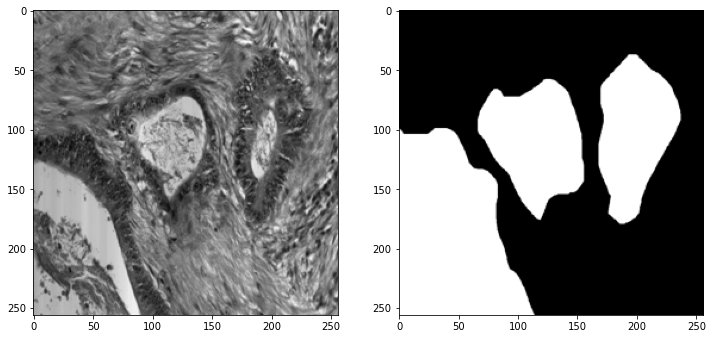

(256, 256, 1)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)
print(len(X_train))
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.show()
print(np.shape(X_train[0]))

In [5]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model





In [6]:
model=unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [7]:
history = model.fit(X_train, y_train, 
                    batch_size = 20, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('unet_model.hdf5')

Epoch 1/100
8/8 [==============================] - 98s 12s/step - loss: 0.6937 - accuracy: 0.4865 - val_loss: 0.6932 - val_accuracy: 0.4705
Epoch 2/100
8/8 [==============================] - 89s 10s/step - loss: 0.6930 - accuracy: 0.4937 - val_loss: 0.6923 - val_accuracy: 0.5183
Epoch 3/100
8/8 [==============================] - 71s 9s/step - loss: 0.6921 - accuracy: 0.5083 - val_loss: 0.6902 - val_accuracy: 0.5700
Epoch 4/100
8/8 [==============================] - 74s 9s/step - loss: 0.6902 - accuracy: 0.5247 - val_loss: 0.6856 - val_accuracy: 0.5960
Epoch 5/100
8/8 [==============================] - 75s 9s/step - loss: 0.6859 - accuracy: 0.5384 - val_loss: 0.6732 - val_accuracy: 0.6093
Epoch 6/100
8/8 [==============================] - 72s 9s/step - loss: 0.6745 - accuracy: 0.5631 - val_loss: 0.6668 - val_accuracy: 0.5381
Epoch 7/100
8/8 [==============================] - 71s 9s/step - loss: 0.6570 - accuracy: 0.5898 - val_loss: 0.6451 - val_accuracy: 0.6069
Epoch 8/100
8/8 [========

8/8 [==============================] - 78s 10s/step - loss: 0.1906 - accuracy: 0.9024 - val_loss: 0.6193 - val_accuracy: 0.8094
Epoch 60/100
8/8 [==============================] - 82s 10s/step - loss: 0.1930 - accuracy: 0.9009 - val_loss: 0.4925 - val_accuracy: 0.8193
Epoch 61/100
8/8 [==============================] - 79s 10s/step - loss: 0.1888 - accuracy: 0.9018 - val_loss: 0.4482 - val_accuracy: 0.8178
Epoch 62/100
8/8 [==============================] - 79s 10s/step - loss: 0.1683 - accuracy: 0.9107 - val_loss: 0.4228 - val_accuracy: 0.8365
Epoch 63/100
8/8 [==============================] - 79s 10s/step - loss: 0.1703 - accuracy: 0.9090 - val_loss: 0.4425 - val_accuracy: 0.8366
Epoch 64/100
8/8 [==============================] - 78s 10s/step - loss: 0.1735 - accuracy: 0.9084 - val_loss: 0.4845 - val_accuracy: 0.8249
Epoch 65/100
8/8 [==============================] - 78s 10s/step - loss: 0.1849 - accuracy: 0.9044 - val_loss: 0.4694 - val_accuracy: 0.8216
Epoch 66/100
8/8 [========

In [8]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 2s 2s/step - loss: 0.7684 - accuracy: 0.8411
Accuracy =  84.10563468933105 %


In [9]:
model = unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.load_weights('unet_model.hdf5') 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

                                                                                                  
 dropout_16 (Dropout)           (None, 128, 128, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_16[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

1/1 [==============================] - 0s 140ms/step
(1, 256, 256, 1)


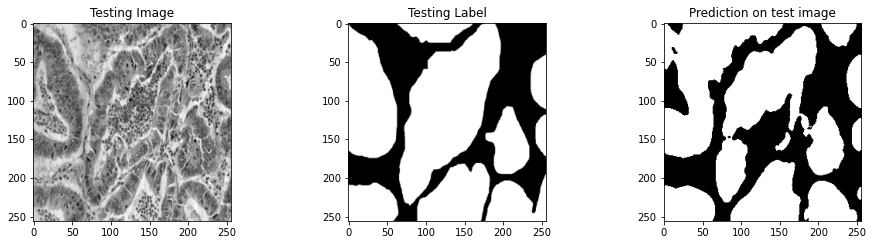

In [10]:

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0]>0.5 ).astype(np.uint8)
preds=model.predict(test_img_input)
print(np.shape(preds))

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')


plt.show()

In [26]:
SIZE=256
image_directory='E:/project work/backup of images/segmentation/TUM/'

#Capture training image info as a list
test_images = []
img_name=[]
images = os.listdir(image_directory)
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        s=image_name
        
        img_name.append(s)
       
        image = cv2.imread(image_directory+image_name, 0)
        image=np.asarray(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_images.append(np.array(image))

test_images = np.expand_dims(normalize(np.array(test_images), axis=1),3)


In [27]:
print(len(test_images))

3600


In [28]:
import cv2
img_dir='E:/project work/backup of images/segmentation/class1/'

for i in range(len(test_images)):
    test_img = test_images[i]

    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0]>0.5 ).astype(np.uint8)
    
    #cv2.imwrite(img_dir+img_name[i],prediction)
    
    
    #plt.title('Prediction on test image')
    #plt.imshow(prediction, cmap='gray')
    filename=img_dir+img_name[i]
    plt.imsave(filename, prediction)
    
    
    

1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 227ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 209ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 209ms/step
